In [8]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import os
from kalman_filter import kalman_filter

In [9]:
direc = "dataset/"
files = sorted(os.listdir(direc))
images = [direc + file for file in files]

In [10]:
# initialise for kalman filter parameters
A = np.array([[1, 0],[0, 1]])
B = np.zeros_like(A)
H = np.array([[1,0],[0,1]])
P = np.array([[100, 0],[0, 100]])
# P = np.array([[0, 0],[0, 0]])
Q = np.zeros_like(P)
R = np.array([[15, 0],[0, 15]])
xo = np.array([[365],[615]])
filter  = kalman_filter(A, B, H, P, Q, R, xo)

In [11]:
S_est = [[] for _ in range(xo.shape[0])]
S_mea = [[] for _ in range(xo.shape[0])]

In [14]:
for i in range(len(images)):
    try:
        frame2 = cv2.imread(images[i+1])
        frame1 = cv2.imread(images[i])
        diff = cv2.absdiff(frame2, frame1)
        gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5,5), 0)

        _, thresh = cv2.threshold(blur, 20, 255, cv2.THRESH_BINARY)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
        dilated = cv2.dilate(thresh, kernel, iterations=10)
        eroded = cv2.erode(dilated, None, iterations=10)

        contours, _ = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        #Get centroid of the rectangular box
        if len(contours) != 0:
            (x, y, w, h) = cv2.boundingRect(contours[0])
            cv2.rectangle(frame1, (x, y), (x+w, y+h), (0, 255, 0), 2)
            M = cv2.moments(contours[0])
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            S_mea[0].append(cx)
            S_mea[1].append(cy)
            # print('[', cx, ' ,' , cy, ']')

        # Display the image stream with rectangular box on tracked object
        cv2.imshow('test video', frame1)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
#         time.sleep(0.01)

        # Implement Kalman Filter
        Z = np.array([[cx],[cy]])               # Observations/Measurements
        state = filter.estimate_state(Z, u = np.zeros_like(Z))
        # Store the estimated x and y for plot
        for i in range(xo.shape[0]):
            S_est[i].append(np.asscalar(state[i]))

    except:
        break
# cv2.destroyAllWindows()

/home/zaid/workspace/computer-vision-assignment/venv/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


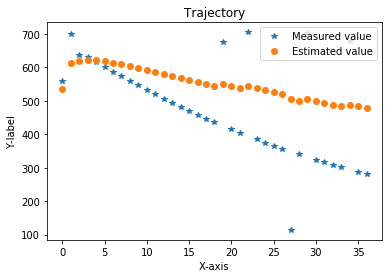

In [6]:
t = list(range(len(S_mea[0])))


i = 0

plt.plot(t, S_mea[i], '*', t, S_est[i], 'o')
plt.xlabel('X-axis')
plt.ylabel('Y-label')
plt.title('Trajectory')
plt.legend(['Measured value', 'Estimated value'], loc='upper right')
plt.show()